In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import sys

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures and animations
%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [2]:
import gym

env = gym.make("CartPole-v0")
obs = env.reset()
print(obs)
env.render()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
[-0.00907352 -0.03790568 -0.01380578 -0.0359716 ]


True

In [3]:
print(env.action_space)

action = 1
obs, reward, done, info = env.step(action)
print(obs, reward, done, info)

env.close()

Discrete(2)
[-0.00983163  0.1574115  -0.01452522 -0.33297822] 1.0 False {}


In [4]:
env = gym.make("CartPole-v0")

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(10):
    episode_rewards= 0
    obs = env.reset()

    for step in range(1000):
        env.render()
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)

        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [5]:
import numpy as np
print(np.mean(totals), np.std(totals), np.min(totals), np.max(totals))

39.9 9.137286249209883 31.0 66.0


In [6]:
import tensorflow as tf

# ニューラルネットワークアーキテクチャを指定する
n_inputs = 4 # env.observatoin_space.shape[0]
n_hidden = 4
n_outputs = 1
initializer = tf.contrib.layers.variance_scaling_initializer()

learning_rate = 0.01

# ニューラルネットワークを構築
X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.layers.dense(hidden, n_outputs, kernel_initializer=initializer)
outputs = tf.nn.sigmoid(logits)

# 推定確率に基づき、無作為に行動を選択する
p_left_and_right = tf.concat(axis=1, values=[outputs, 1-outputs])
action = tf.multinomial(tf.log(p_left_and_right), num_samples=1)

y = 1. - tf.to_float(action)

cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars]

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
    gradient_placeholder = tf.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.empty(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards

    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]


In [8]:
discount_rewards([10, 0, -50], discount_rate=0.8)

array([-22., -40., -50.])

In [9]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_rate=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [10]:
n_iterations = 250
n_max_steps = 1000
n_games_per_update = 10
save_iterations = 10
discount_rate = 0.95

env = gym.make("CartPole-v0")

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run(
                    [action, gradients],
                    feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)
        
        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate)
        feed_dict = {}
        for var_index, grad_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean(
                [reward * all_gradients[game_index][step][var_index]
                     for game_index, rewards in enumerate(all_rewards)
                     for step, reward in enumerate(rewards)],
                axis=0)
            feed_dict[grad_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            print(iteration)
            saver.save(sess, "./my_policy_net_pg.ckpt")

env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240


In [11]:
env.close()

## DQN

In [24]:
env = gym.make("MsPacman-v0")
obs = env.reset()
obs.shape

(210, 160, 3)

In [38]:
mspacman_color = 210 + 164 + 74

def preprocess_observation(obs):
    img = obs[1:176:2, ::2]
    img = img.sum(axis=2)
    img[img==mspacman_color] = 0
    img = (img // 3 - 128).astype(np.int8)
    w, h = img.shape
    return img.reshape(w, h, 1)

(88, 80, 1)


<IPython.core.display.Javascript object>


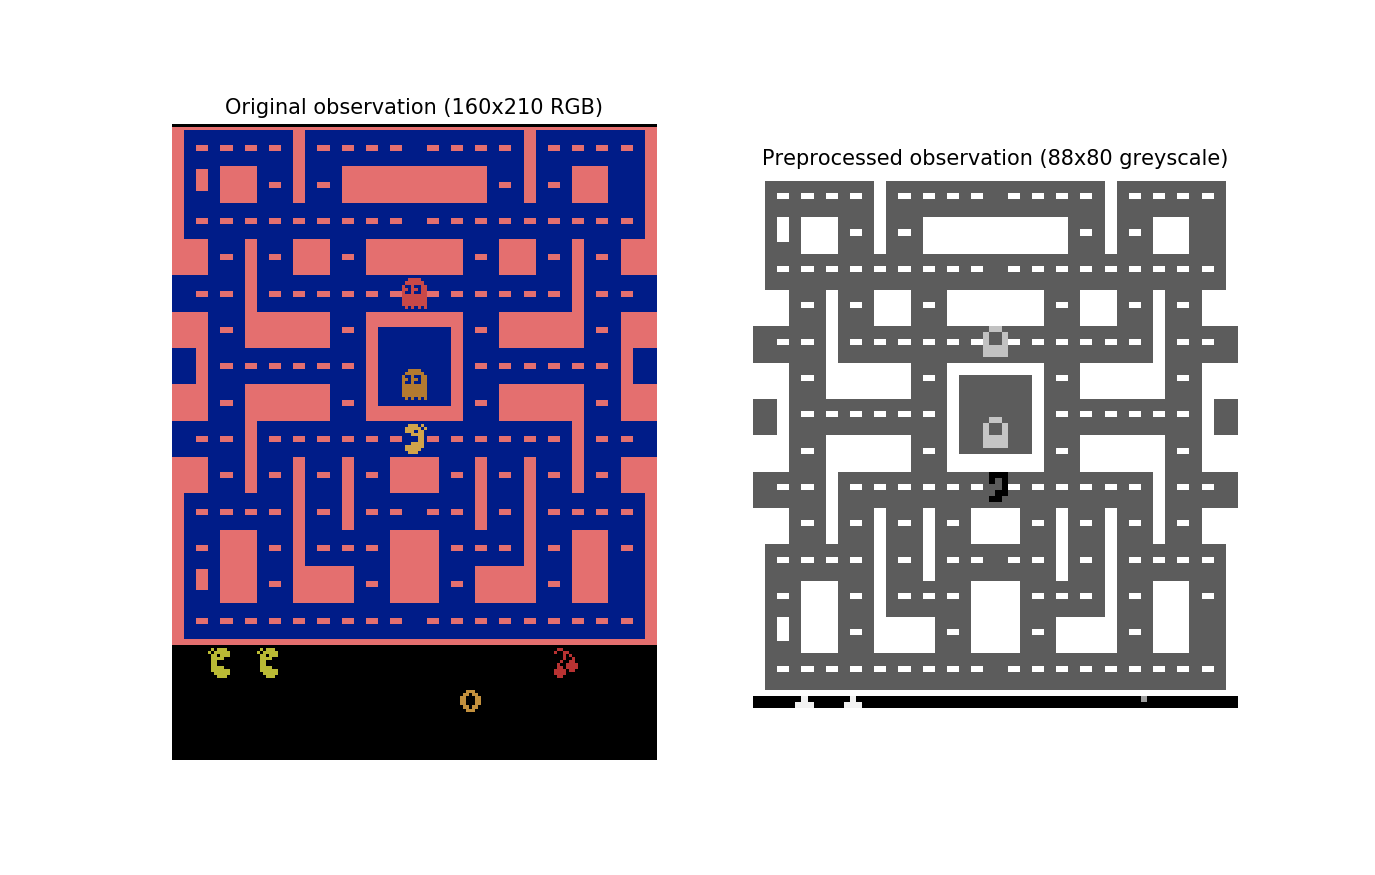

In [43]:
plt.figure(figsize=(11, 7))
plt.subplot(121)
plt.title('Original observation (160x210 RGB)')
plt.imshow(obs)
plt.axis('off')

plt.subplot(122)
plt.title('Preprocessed observation (88x80 greyscale)')
img = preprocess_observation(obs)
plt.imshow(img.reshape(88, 80), interpolation='nearest', cmap='gray')
plt.axis('off')

plt.show()

In [64]:
reset_graph()

input_height = 88
input_width = 80
input_channels = 1
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [(8,8), (4,4), (3,3)]
conv_strides = [4, 2, 1]
conv_paddings = ["SAME"] * 3 
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 64 * 11 * 10  # conv3 has 64 maps of 11x10 each
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = env.action_space.n  # 9 discrete actions are available
initializer = tf.variance_scaling_initializer()

def q_network(X_state, name):
    prev_layer = X_state / 128.0 # scale pixel to [-1.0, 1.0] range
    with tf.variable_scope(name) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
                conv_n_maps, conv_kernel_sizes, conv_strides,
                conv_paddings, conv_activation):
            prev_layer = tf.layers.conv2d(
                prev_layer, filters=n_maps, kernel_size=kernel_size,
                strides=strides, padding=padding, activation=activation,
                kernel_initializer=initializer)
        last_conv_layer_flat = tf.reshape(prev_layer, shape=[-1, n_hidden_in])
        hidden = tf.layers.dense(last_conv_layer_flat, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=initializer)
        outputs = tf.layers.dense(hidden, n_outputs,
                                 kernel_initializer=initializer)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                      scope=scope.name)
    print(trainable_vars)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name


In [65]:
X_state = tf.placeholder(tf.float32, shape=[None, input_height, input_width,
                                           input_channels])            
online_q_values, online_vars = q_network(X_state, name="q_networks/online")
target_q_values, target_vars = q_network(X_state, name="q_networks/target")

copy_ops = [target_var.assign(online_vars[var_name])
           for var_name, target_var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)

[<tf.Variable 'q_networks/online/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>, <tf.Variable 'q_networks/online/conv2d/bias:0' shape=(32,) dtype=float32_ref>, <tf.Variable 'q_networks/online/conv2d_1/kernel:0' shape=(4, 4, 32, 64) dtype=float32_ref>, <tf.Variable 'q_networks/online/conv2d_1/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'q_networks/online/conv2d_2/kernel:0' shape=(3, 3, 64, 64) dtype=float32_ref>, <tf.Variable 'q_networks/online/conv2d_2/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'q_networks/online/dense/kernel:0' shape=(7040, 512) dtype=float32_ref>, <tf.Variable 'q_networks/online/dense/bias:0' shape=(512,) dtype=float32_ref>, <tf.Variable 'q_networks/online/dense_1/kernel:0' shape=(512, 9) dtype=float32_ref>, <tf.Variable 'q_networks/online/dense_1/bias:0' shape=(9,) dtype=float32_ref>]
[<tf.Variable 'q_networks/target/conv2d/kernel:0' shape=(8, 8, 1, 32) dtype=float32_ref>, <tf.Variable 'q_networks/target/conv2d/bias:0' shape=(32,) dtype=f

In [67]:
learning_rate = 0.001
momentum = 0.95

with tf.variable_scope("train"):
    X_action = tf.placeholder(tf.int32, shape=[None])
    y = tf.placeholder(tf.float32, shape=[None, 1])
    q_value = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),
                           axis=1, keepdims=True)
    error = tf.abs(y - q_value)
    cliped_error = tf.clip_by_value(error, 0.0, 1.0)
    linear_error = 2 * (error - cliped_error)
    loss = tf.reduce_mean(tf.square(cliped_error) + linear_error)
    
    global_step = tf.Variable(0, trainable=False, name="global_step")
    optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,
                                           momentum=momentum,
                                           use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [69]:
class ReplayMemory:
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0
        
    def append(self, data):
        self.buf[self.index] = data
        self.length = min(self.length + 1, self.maxlen)
        self.index = (self.index + 1) % self.maxlen
    
    def sample(self, batch_size, with_replacement=True):
        if with_replacement:
            indices = np.random.randint(self.length, size=batch_size) # faster
        else:
            indices = np.random.permutation(self.length)[:batch_size]
        return self.buf[indices]

In [72]:
replay_memory_size = 500000
replay_memory = ReplayMemory(replay_memory_size)


def sample_memories(batch_size):
    cols = [[], [], [], [], []] # state, action, reward, next_state, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0], cols[1], cols[2].reshape(-1, 1), cols[3], cols[4].reshape(-1, 1)

In [73]:
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 2000000

def epsilon_greedy(q_values, step):
    epsilon = max(eps_min, eps_max - (eps_max - eps_min) * step / eps_decay_steps)
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return np.argmax(q_values)

In [74]:
n_steps = 4000000  # 訓練ステップ数
training_start = 10000  # 10000回ゲームをプレイしてから訓練を始める
training_interval = 4  # 4回ゲームをプレイするたびに訓練を開始する
save_steps = 1000  # 1000 訓練ステップごとにモデルを保存する
copy_steps = 10000  # 10000 訓練ステップごとにオンラインDQNをターゲットDQNにコピーする
discount_rate = 0.99
skip_start = 90  # すべてのゲームの冒頭 (ただの待ち時間) をスキップする
batch_size = 50
iteration = 0  # ゲームイテレーション
checkpoint_path = "./my_dqn.ckpt"
done = True # 環境のリセットが必要か

In [79]:
with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + ".index"):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        sess.run(copy_online_to_target)
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        if done: # ゲームオーバー、やりなおし
            obs = env.reset()
            for skip in range(skip_start): # 各ゲームのはじめにスキップ
                obs, _, done, _ = env.step(0)
            state = preprocess_observation(obs)
        
        # オンライン DQL を評価
        q_values = online_q_values.eval(feed_dict={X_state: [state]})
        action = epsilon_greedy(q_values, step)
        
        # オンライン DQN がプレイ
        obs, reward, done, info = env.step(action)
        next_state = preprocess_observation(obs)
        
        # 起きたことを記録する
        replay_memory.append((state, action, reward, next_state, 1.0 - done))
        state = next_state
        
        if iteration < training_start or iteration % training_interval != 0:
            continue # ウォームアップ期間の後で、かつ一定の間隔で訓練する
        
        # 記憶をサンプリングし、ターゲット Q 値を作るためにターゲット DQN を使う
        X_state_val, X_action_val, rewards, X_next_state_val, continues = (
            sample_memories(batch_size))
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values
        
        # オンライン DQN を訓練する
        sess.run(training_op, feed_dict={X_state: X_state_val,
                                  X_action: X_action_val,
                                  y: y_val})
        
        # 定期的にオンライン DQN をターゲット DQN にコピーする
        if step % copy_steps == 0:
            sess.run(copy_online_to_target)
        
        # 定期的に保存する
        if step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from ./my_dqn.ckpt


KeyboardInterrupt: 